Populating the interactive namespace from numpy and matplotlib
/content


Saving UniqloTrainingstocks1216.csv to UniqloTrainingstocks1216 (1).csv


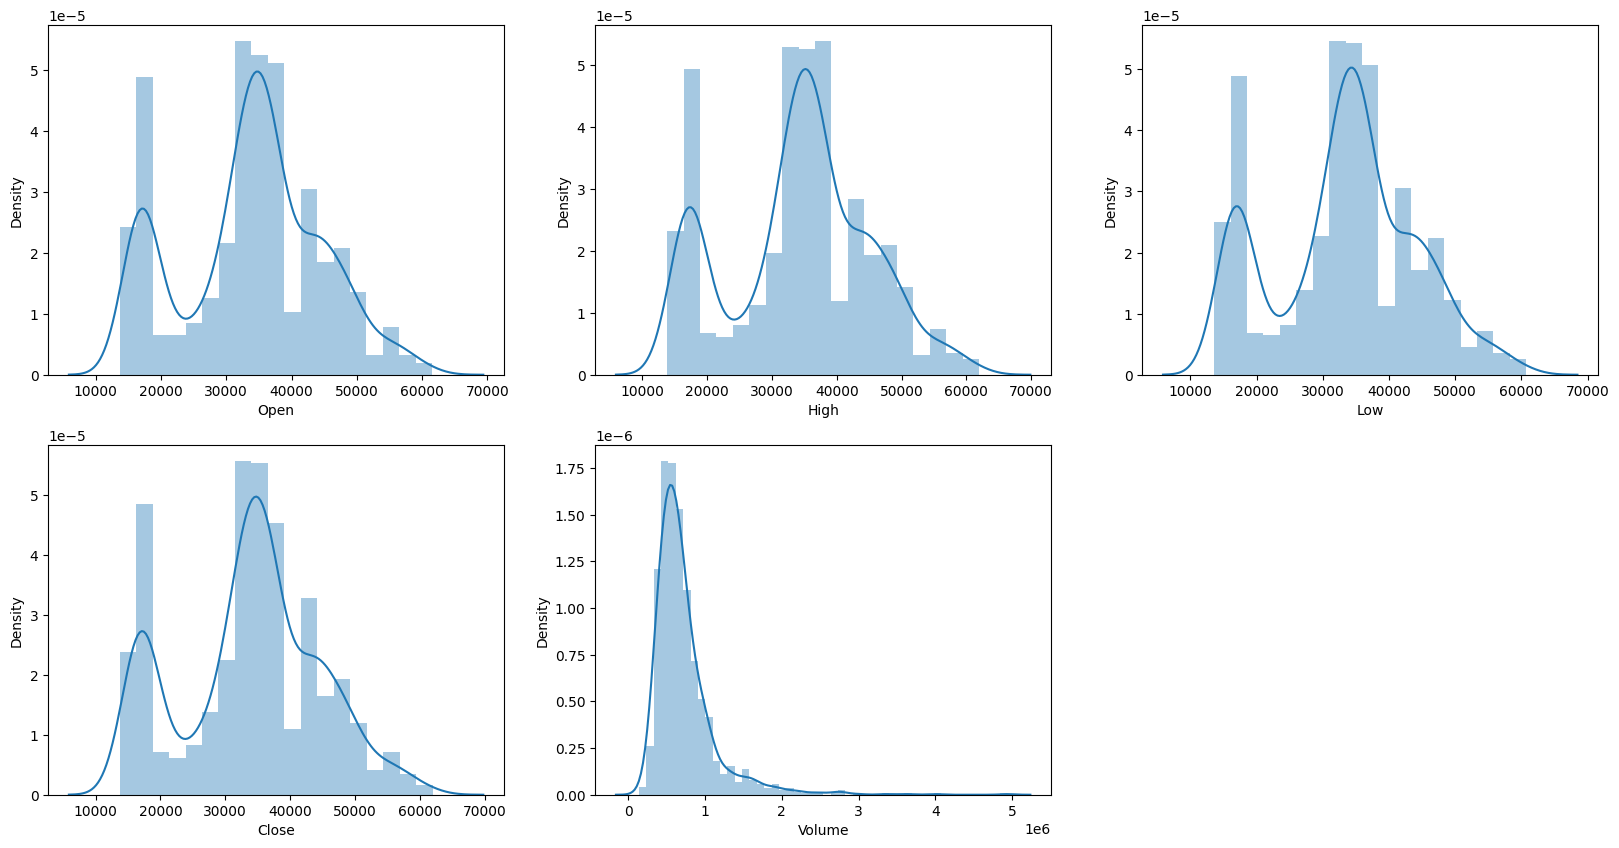

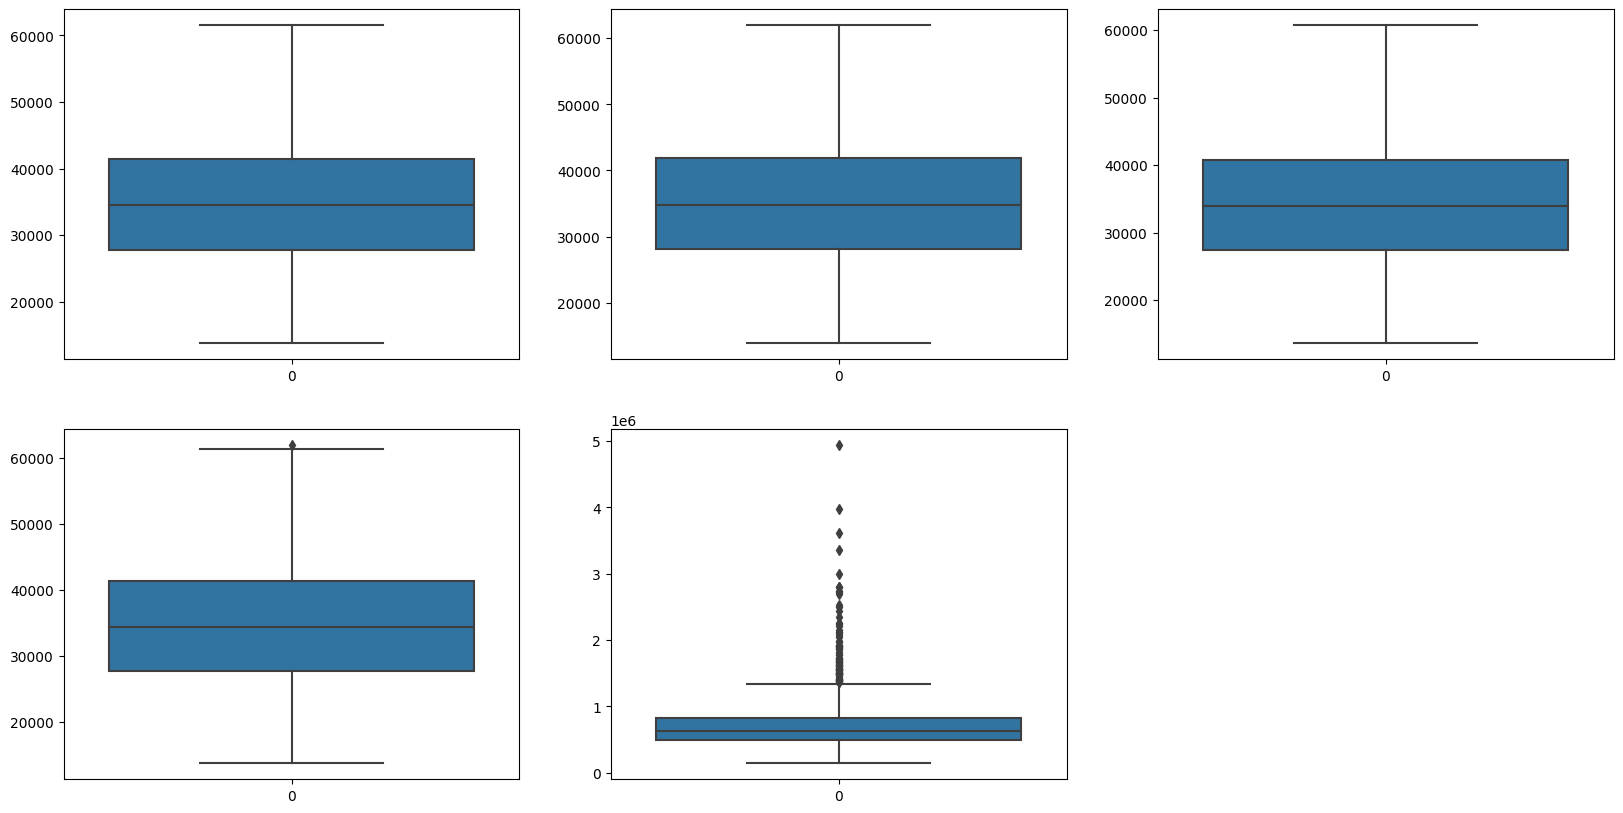

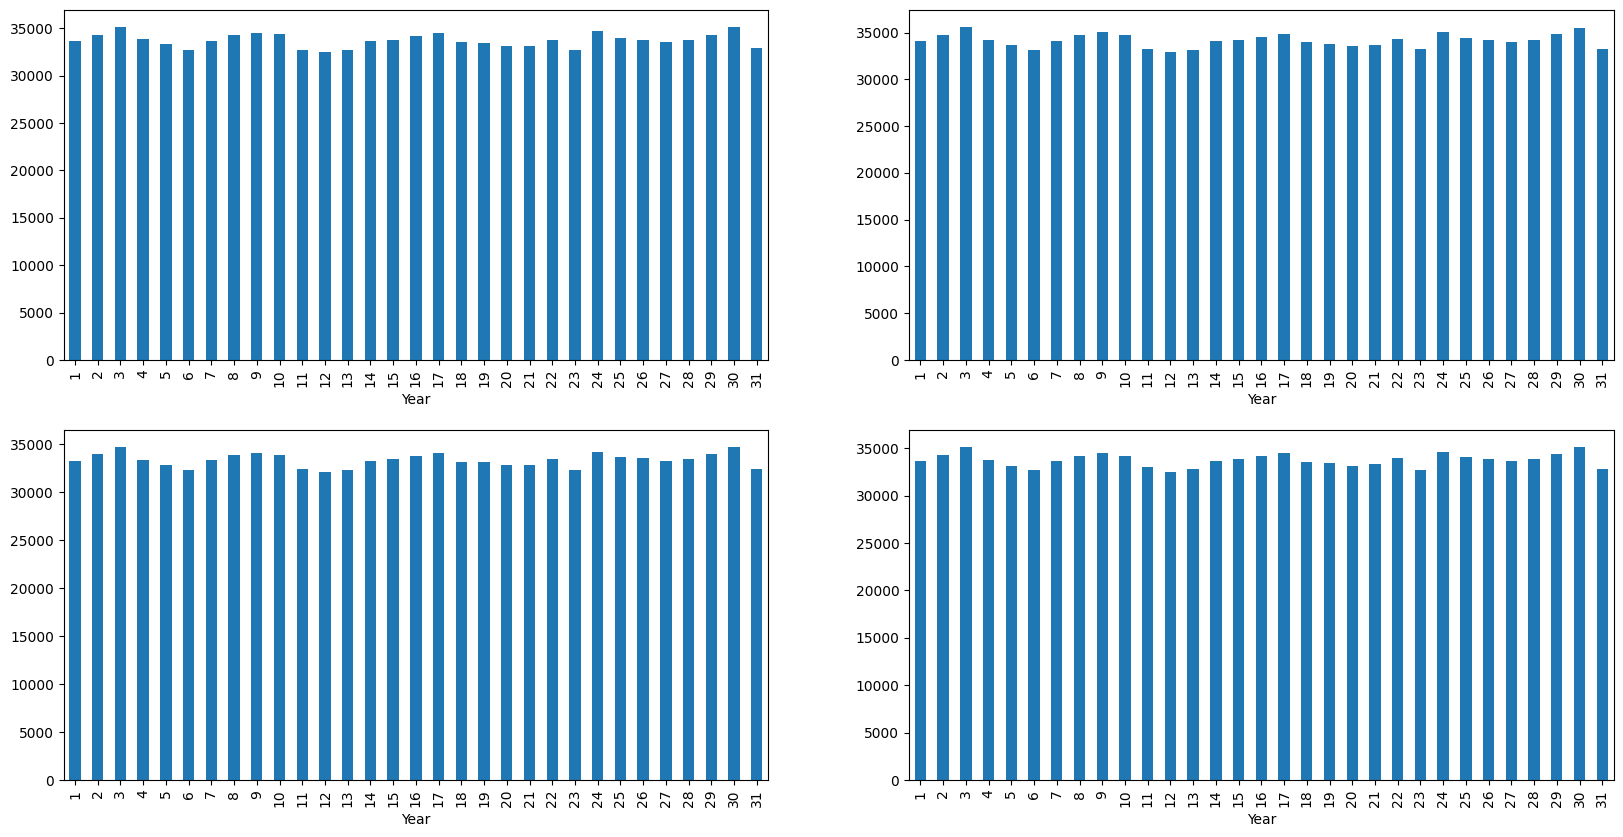

(1103, 3) (123, 3)
LogisticRegression() : 
Training Accuracy :  0.8677613693351282
Validation Accuracy :  0.8238726790450929

SVC(kernel='poly', probability=True) : 
Training Accuracy :  0.8611924934674162
Validation Accuracy :  0.8294429708222811

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn import metrics

! pip install chart_studio

from chart_studio.plotly import iplot
import plotly.graph_objs as go
import warnings
warnings.filterwarnings('ignore')
%pylab inline

!pwd

from google.colab import files

uploaded = files.upload()
datatrain = pd.read_csv("/content/UniqloTrainingstocks1216.csv")

datatrain.head()

chart1 = go.Figure(data=[go.Candlestick(x=datatrain['Date'],
                open=datatrain['Open'],
                high=datatrain['High'],
                low=datatrain['Low'],
                close=datatrain['Close'])])

chart1.show()

#EDA
features = ['Open', 'High', 'Low', 'Close', 'Volume']

plt.subplots(figsize=(20,10))

for i, col in enumerate(features):
  plt.subplot(2,3,i+1)
  sns.distplot(datatrain[col])
plt.show()

# From the distribution plots we can see that the Volume data is left skewed and across OHLC, there are two major peaks

plt.subplots(figsize=(20,10))
for i, col in enumerate(features):
  plt.subplot(2,3,i+1)
  sns.boxplot(datatrain[col])
plt.show()

#From the boxplots we can see that the Volume data has outliers

splitted = datatrain['Date'].str.split('-', expand=True)

datatrain['Year'] = splitted[0].astype('int')
datatrain['Month'] = splitted[1].astype('int')
datatrain['Day'] = splitted[2].astype('int')

datatrain['is_quarter_end'] = np.where(datatrain['Month']%3==0,1,0)

data_grouped = datatrain.groupby('Year').mean()
plt.subplots(figsize=(20,10))

for i, col in enumerate(['Open', 'High', 'Low', 'Close']):
  plt.subplot(2,2,i+1)
  data_grouped[col].plot.bar()
plt.show()

#We can see from the quarterly data that Uniqlo's stock price increases by almost 2.5x from 2012 - 2015 and then reduced in 2016

datatrain.groupby('is_quarter_end').mean()

#Prices and volumes traded are higher at the end of a quarter

#Modelling
datatrain['open-close']  = datatrain['Open'] - datatrain['Close']
datatrain['low-high']  = datatrain['Low'] - datatrain['High']
datatrain['target'] = np.where(datatrain['Close'].shift(-1) > datatrain['Close'], 1, 0)

features = datatrain[['open-close', 'low-high', 'is_quarter_end']]
target = datatrain['target']

scaler = StandardScaler()
features = scaler.fit_transform(features)

X_train, X_test, Y_train, Y_test = train_test_split(
    features, target, test_size=0.1, random_state=2022)
print(X_train.shape, X_test.shape)

models = [LogisticRegression(), SVC(
  kernel='poly', probability=True), XGBClassifier()]

for i in range(3):
  models[i].fit(X_train, Y_train)

  print(f'{models[i]} : ')
  print('Training Accuracy : ', metrics.roc_auc_score(
    Y_train, models[i].predict_proba(X_train)[:,1]))
  print('Validation Accuracy : ', metrics.roc_auc_score(
    Y_test, models[i].predict_proba(X_test)[:,1]))
  print()

#While XBGClassifier has the highest accuracy for training data, the large difference between the accuracy for training and test data shows it's prone to overfitting for which reason Logistic Regression is the best method to be used here